# Subsurface Modeling

**Author:** Hasan Shojaei (hasan.shojaei@gmail.com)

We are given a dataset containing geologic, completions and production data for 115 hydraulically-fractured horizontal wells in the Permian Basin. Our goal is to explore the data, test some of our hypotheses about the data, and come up with predictive models for oil production from these wells. 

## Importing Required Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

## Reading in the Data

In [2]:
WellData = pd.read_csv("WellData.csv", index_col=0)

In [3]:
WellData.shape

(115, 21)

In [4]:
WellData.columns

Index(['TargetFormation', 'TargetFormationThickness', 'BVW', 'PHIT', 'PR',
       'SWT', 'VCL', 'YM', 'PGRAD', 'P_Res', 'GOR', '3D_Spacing', 'LAT_LENGTH',
       'PPG', 'Prop_ft', 'Fluid_ft', 'Avg_Stg_Len', 'Avg_Clust_Spc',
       'Clusters_per_Stage', 'Rate_per_cluster', 'CumOil_24Months'],
      dtype='object')

In [5]:
# Convert TargetFormation to a Categorical variable
WellData['TargetFormation'] = pd.Categorical(WellData['TargetFormation'])

## Exploratory Data Analysis

In [6]:
WellData.groupby('TargetFormation').size()

TargetFormation
A    21
B    94
dtype: int64

##### Thoughts:
- Formation B appears to be the main focus of the operator where they have drilled most of their wells

### Geology

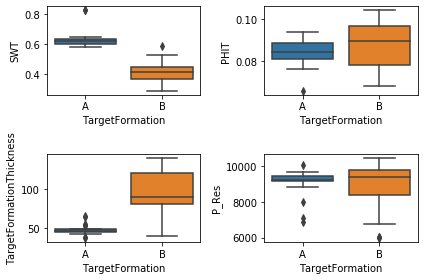

In [7]:
geologic_prop = ['SWT', 'PHIT', 'TargetFormationThickness', 'P_Res']
fig, axes = plt.subplots(2,2)
axes = axes.ravel()

for i in range(len(geologic_prop)):
    sns.boxplot(x="TargetFormation", y=geologic_prop[i], data=WellData, ax=axes[i])

fig.tight_layout()

**Thoughts:**
- Formation B has more favorable geology: lower water content (SWT) which means higher oil content, higher porosity, and larger thickness. The more favorable geology justifies Formation B bering the main focus of the operator. 

### Completions

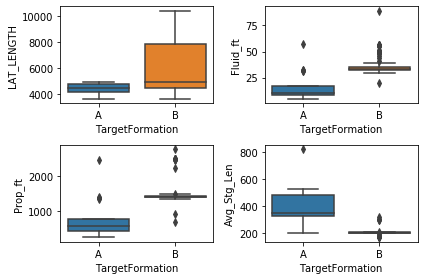

In [8]:
completion_param = ['LAT_LENGTH', 'Fluid_ft', 'Prop_ft', 'Avg_Stg_Len']
fig, axes = plt.subplots(2,2)
axes = axes.ravel()

for i in range(len(geologic_prop)):
    sns.boxplot(x="TargetFormation", y=completion_param[i], data=WellData, ax=axes[i])

fig.tight_layout()

**Thoughts:**
- Formation B-landed wells have larger completions and longer laterals. The trend in the industry has been to drill longer laterals and complete with larger volumes in the recent years. 

### Production Response

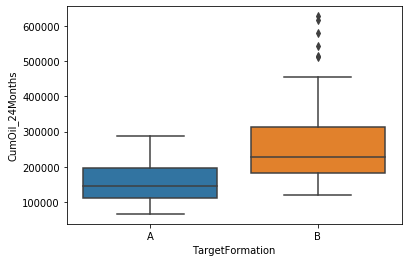

In [9]:
ax = sns.boxplot(x="TargetFormation", y="CumOil_24Months", data=WellData)

**Thoughts:**
- On average, formation B-landed wells produce more oil
- This is to be expected because both geology and completion designs are more favorable for formation B-landed wells

## Statistical Testing

Let's test if the observed difference in average oil production from B- vs. A-landed wells is statistically significant

In [10]:
cat1 = WellData[WellData['TargetFormation']=='A']
cat2 = WellData[WellData['TargetFormation']=='B']

ttest_ind(cat1['CumOil_24Months'], cat2['CumOil_24Months'])

Ttest_indResult(statistic=-4.281592055934412, pvalue=3.910261959001755e-05)

**Thoughts:**
- p-value is less than 0.05, therefore we are confident that the observed difference in mean production responses between formation A & B wells is statistically significant  

## Multiple Regression

We want to build models using multiple regression. But first let's explore the data further.  

### Exploring correlation among Parameters

In [11]:
X0 = WellData.iloc[:,1:]

In [12]:
corr = X0.corr().abs()
# corr.style.background_gradient()

In [13]:
# Correlation between production response and the features
corr_abs = corr.iloc[:,-1].abs()

In [14]:
corr_abs.sort_values(ascending=False)

CumOil_24Months             1.000000
LAT_LENGTH                  0.616531
Prop_ft                     0.445139
Fluid_ft                    0.415044
Avg_Stg_Len                 0.373362
Rate_per_cluster            0.369662
Avg_Clust_Spc               0.357587
PR                          0.356846
TargetFormationThickness    0.353170
Clusters_per_Stage          0.332024
SWT                         0.279589
VCL                         0.265382
P_Res                       0.226213
BVW                         0.218873
YM                          0.209488
PPG                         0.143675
PHIT                        0.135013
3D_Spacing                  0.112217
PGRAD                       0.097847
GOR                         0.025537
Name: CumOil_24Months, dtype: float64

**Thoughts:**
- The table above ranks the features based on the correlation of response variable (CumOil_24Months) with them
- Some of these features are highly correlated ( > 0.7) with each other
- Excluding features that have a large correlation with each other (i.e. removing multi-colinearilty), we arrive at these 7 most important features:
    - LAT_LENGTH, Prop_ft, Avg_Stg_Len, TargetFormationThickness, SWT, VCL, P_Res

### Splitting Data into Training and Test Sets

In [15]:
# select all completion and geology parameters as regressors
X = WellData.iloc[:,1:20]

Let's take a look at the distribution of our desired response variable (CumOil_24Months):

''

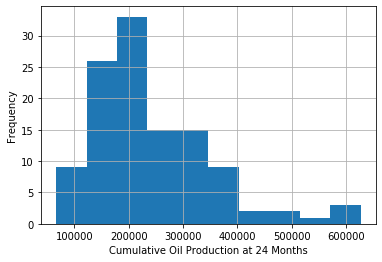

In [16]:
fig, ax = plt.subplots()
WellData['CumOil_24Months'].hist(ax=ax)
ax.set_xlabel('Cumulative Oil Production at 24 Months')
ax.set_ylabel('Frequency')
,

This is a skewed dsitribution and we need to transform the response variable (log transformation) before running through regression. 

''

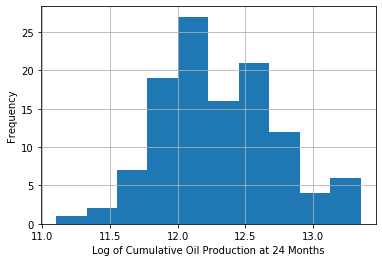

In [17]:
# select Log of 24 Months Cum Oil production as the response variable
y = WellData.iloc[:,20:21]
y.CumOil_24Months = y.CumOil_24Months.apply(np.log)
y.columns = ['LogCumOil_24m']

fig, ax = plt.subplots()
y['LogCumOil_24m'].hist(ax=ax)
ax.set_xlabel('Log of Cumulative Oil Production at 24 Months')
ax.set_ylabel('Frequency')
,

The new response variable looks more normal now, and can be used in multiple regression.

In [18]:
# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Multiple Regression using All Features

In [19]:
modelFit1 = LinearRegression().fit(X_train, y_train)

In [20]:
# Make predictions using the training & testing set
y_pred_train = modelFit1.predict(X_train)
y_pred_test = modelFit1.predict(X_test)

In [21]:
# R^2 for training set
modelFit1.score(X_train, y_train)

0.6717152349574667

In [22]:
# Adjusted R^2 for training set
1 - (1-modelFit1.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)

0.5772090147179495

In [23]:
# R^2 for test set
modelFit1.score(X_test, y_test)

0.5977319390788904

In [24]:
# Adjusted R^2 for test set
1 - (1-modelFit1.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)

-0.25150063397678535

''

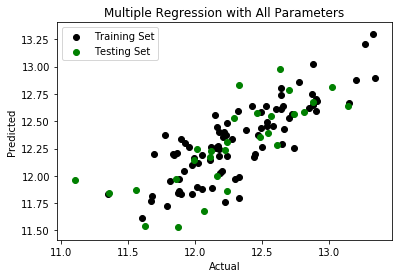

In [25]:
fig, ax = plt.subplots()
ax.scatter(y_train, y_pred_train,  color='black', label='Training Set')
ax.scatter(y_test, y_pred_test,  color='green', label='Testing Set')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title('Multiple Regression with All Parameters')
ax.legend()
,

**Thoughts:**
- The performance of the model deteriorates when we apply it to the test set (0.60 vs. 0.67 coefficient of determination), which is expected

### Multiple Regression using 7 Most Important Features

In [26]:
# select the 7 most important completion and geology parameters as regressors
X_train2 = X_train[['LAT_LENGTH','Prop_ft','Avg_Stg_Len','TargetFormationThickness','SWT','VCL','P_Res']]
X_test2 = X_test[['LAT_LENGTH','Prop_ft','Avg_Stg_Len','TargetFormationThickness','SWT','VCL','P_Res']]

In [27]:
modelFit2 = LinearRegression().fit(X_train2, y_train)

In [28]:
# Make predictions using the training & testing set
y_pred_train2 = modelFit2.predict(X_train2)
y_pred_test2 = modelFit2.predict(X_test2)

In [29]:
# R^2 for training set
modelFit2.score(X_train2, y_train)

0.5418090365194201

In [30]:
# Adjusted R^2 for training set
1 - (1-modelFit2.score(X_train2, y_train))*(len(y_train)-1)/(len(y_train)-X_train2.shape[1]-1)

0.5006893346685989

In [31]:
# R^2 for test set
modelFit2.score(X_test2, y_test)

0.7037285456512363

In [32]:
# Adjusted R^2 for test set
1 - (1-modelFit2.score(X_test2, y_test))*(len(y_test)-1)/(len(y_test)-X_test2.shape[1]-1)

0.6049713942016485

''

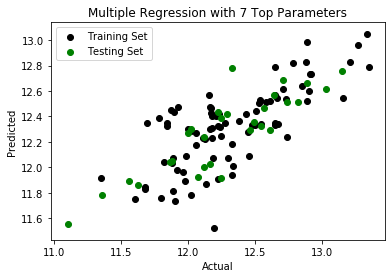

In [33]:
fig, ax = plt.subplots()
ax.scatter(y_train, y_pred_train2,  color='black', label='Training Set')
ax.scatter(y_test, y_pred_test2,  color='green', label='Testing Set')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title('Multiple Regression with 7 Top Parameters')
ax.legend()
,

**Thoughts:**
- The performance of the model improves when we apply it to the test set (0.70 vs. 0.54 coefficient of determination), which is usually not expected
- modelFit2 performs better when we consider test sets (see adjusted R^2), but not when we consider training sets

## Random Forest Model

In [34]:
# convert feature data frame to a numpy array, but first save feature names for later
feature_list = list(X_train.columns)
X_train = np.array(X_train)
y_train = np.ravel(y_train)

In [35]:
X_test = np.array(X_test)
y_test = np.ravel(y_test)

In [36]:
rf = RandomForestRegressor(max_depth=2, random_state=42, n_estimators=100)

In [37]:
# fit a model to the training data set
modelFit3 = rf.fit(X_train, y_train)

In [38]:
# R^2 for training set
modelFit3.score(X_train, y_train)

0.6569572695373105

In [39]:
# R^2 for testing set
modelFit3.score(X_test, y_test)

0.4257708703283104

**Thoughts:**
   
   - Random Forest regressor is unable to outperform the multiple regression model built with 7 top features. Therefore out of the three models built here, we can call the multiple regression model built with 7 top features the `best parsimonious model`

## Unsupervised Clustering using PCA

At the end let's see if PCA of geologic properties can cluster the wells into formation A vs. formation B

In [40]:
# select only geologic parameters
X3 = X.iloc[:,0:10].copy()

# standardize the features
X3 = StandardScaler().fit_transform(X3)

In [41]:
pca = PCA()  
projected = pca.fit_transform(X3)

In [42]:
WellData['Color'] = WellData['TargetFormation']
WellData.Color.replace({'A': 'red',
                        'B':'blue'}, inplace=True)

''

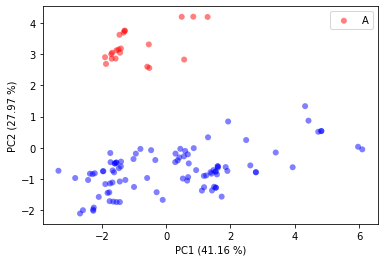

In [43]:
fig, ax = plt.subplots()
ax.scatter(projected[:, 0], projected[:, 1],
            c=WellData.Color, edgecolor='none', alpha=0.5)

ax.set_xlabel('PC1 ({} %)'.format(round(pca.explained_variance_ratio_[0]*100, 2)))
ax.set_ylabel('PC2 ({} %)'.format(round(pca.explained_variance_ratio_[1]*100, 2)))
ax.legend(WellData['TargetFormation'].unique()[0:2])
,

**Thoughts:**
- Principal component analysis is successfull in unsupervised clustering of wells into formation A vs. Formation B wells
- PC2 separates formation A from Formation B wells